In [2]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import nltk
from sklearn.decomposition import PCA
import pylab as plt
from nltk.corpus import words
import pandas as pd
import sys
from scipy import spatial
from collections import Counter
import networkx as nx
from collections import defaultdict
from matplotlib.colors import ListedColormap
import json
from PIL import Image
from pylab import *
import numpy as np
from io import StringIO, BytesIO
import matplotlib.cm as cm
from urllib.request import urlopen, Request
import re

import conda
import os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()


In [29]:
# read Yelp! data
# download from:  https://github.com/melqkiades/yelp/blob/master/notebooks/yelp_academic_dataset_business.json
f = open('/Users/lingfeiw/Documents/teaching/INFOVIZ/yelp_academic_dataset_business.json')
d = [json.loads(i) for i in f]
e = {}
for i in d:
    if i['city']=='Tempe' and 'Restaurants' in i['categories']:
        e[i['name']] = [i['longitude'],i['latitude'],i['stars']]

In [4]:
len(e)

451

In [57]:
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
  return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
  n = 2.0 ** zoom
  lon_deg = xtile / n * 360.0 - 180.0
  lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
  lat_deg = math.degrees(lat_rad)
  return (lat_deg, lon_deg)

def getImageCluster(lat_deg, lon_deg, delta_lat,  delta_long, zoom):
    smurl = r"http://a.tile.openstreetmap.org/{0}/{1}/{2}.png"
    xmin, ymax = deg2num(lat_deg, lon_deg, zoom)
    xmax, ymin = deg2num(lat_deg + delta_lat, lon_deg + delta_long, zoom)

    bbox_ul = num2deg(xmin, ymin, zoom)
    bbox_ll = num2deg(xmin, ymax + 1, zoom)
    #print bbox_ul, bbox_ll

    bbox_ur = num2deg(xmax + 1, ymin, zoom)
    bbox_lr = num2deg(xmax + 1, ymax +1, zoom)
    #print bbox_ur, bbox_lr

    Cluster = Image.new('RGB',((xmax-xmin+1)*256-1,(ymax-ymin+1)*256-1) )
    for xtile in range(xmin, xmax+1):
        for ytile in range(ymin,  ymax+1):
            try:
                imgurl=smurl.format(zoom, xtile, ytile)
                #print("Opening: " + imgurl)
                headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
                request=Request(imgurl,None,headers) #The assembled request
                response = urlopen(request)
                imgstr = response.read()
                tile = Image.open(BytesIO(imgstr))
                Cluster.paste(tile, box=((xtile-xmin)*255 ,  (ytile-ymin)*255))
            except: 
                print("Couldn't download image")
                tile = None

    return (Cluster, (bbox_ll[1], bbox_ll[0], bbox_ur[1], bbox_ur[0]))

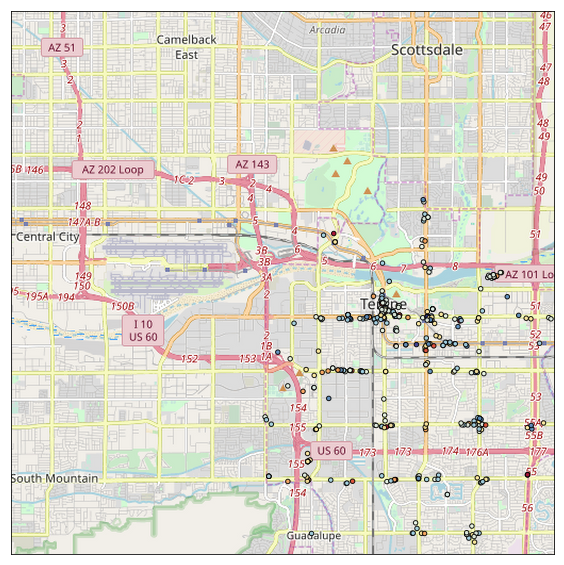

In [64]:
lat_deg, lon_deg, delta_lat,  delta_long, zoom = 33.42551-0.04/2, -111.940005-0.08/2, 0.04,  0.08, 12
a, bbox = getImageCluster(lat_deg, lon_deg, delta_lat,  delta_long, zoom)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m = Basemap(
    llcrnrlon=bbox[0], llcrnrlat=bbox[1],
    urcrnrlon=bbox[2], urcrnrlat=bbox[3],
    projection='merc', ax=ax
)
# list of points to display (long, lat)
ls_points = [m(x,y) for x,y in [(e[i][0],e[i][1]) for i in e]]
colors = [e[i][-1] for i in e]
cm = plt.cm.get_cmap('RdYlBu')
m.imshow(a, interpolation='lanczos', origin='upper')
ax.scatter([point[0] for point in ls_points],
           [point[1] for point in ls_points],
           alpha = 0.9,s=20,c=colors,cmap=cm,edgecolor='k')
plt.show()